# Controle Quântico Ótimo - Utilização do CG para ajuste do caminho percorrido por uma partícula

Nessa etapa, é necessário avaliar, a partir da equação de Heisenberg, com o método de Runge-Kutta e com o controle MPC, como a curva de origem ajusta-se a curva de destino. Além disso, é interessantíssimo a avaliação a partir do estado estacionário e ainda verificar como ocorre o ajuste de fases.

In [1]:
# Bilbiotecas para auxílio na programação matemática
import math, sys 
import numpy as np
import sympy as sp

from scipy import sparse # Produção das diagonais das matrizes
from scipy.sparse import diags 

# Plotagem 2D e 3D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


from os import path # Suficiente para manipulação de arquivos
    
# Para solução exata
from scipy.special import hermite
from math import factorial

%matplotlib inline
count = 0

# Para otimização dos sistemas
from scipy import optimize

import random

Abaixo se dão os requisitos básicos para a instauração do teste. Se tem formas de subtrair e somar matrizes, a manipulação das derivadas com o Runge-Kutta além da própria proposta da função objetivo.

In [2]:
# Manipulação das matrizes

def somar(A, B):
    C = []
    nLinhasA, nLinhasB = len(A), len(B)
    nColA, nColB = len(A[0]), len(B[0])
    
    for i in range (nLinhasA):
        linha = [0]*nColA
        C.append(linha)
        for j in range(nColA):
            C[i][j] = A[i][j] + B[i][j]

    return C

def sub(A, B):
    C = []
    nLinhasA, nLinhasB = len(A), len(B)
    nColA, nColB = len(A[0]), len(B[0])
    
    for i in range (nLinhasA):
        linha = [0]*nColA
        C.append(linha)
        for j in range(nColA):
            C[i][j] = A[i][j] - B[i][j]

    return C


#################################################################

## d (psi) / dt = -i * H * |psi>
def dpsidt(t,psi, H):
    A = np.zeros((2,2), dtype=np.complex_)
    A = np.dot(complex(0,1),H) # i * H
    return -1*np.matmul(A,psi) # - i * H * |psi>

# Runge-Kutta de quarta ordem

def rungeKutta(psi0, h, H, t = 2, t0 = 0):
    
    S = np.zeros((2,int(10*t)), dtype=np.complex_)
    r = 0

    for i in np.arange(t0, t, 0.1):
        
        S[0][r] = psi0[0][0]
        S[1][r] = psi0[1][0]
        
        k1 = dpsidt(t0, psi0, H)
        k2 = dpsidt(t0 + 0.5 * h, somar(psi0, np.dot((0.5*h), k1)), H)
        k3 = dpsidt(t0 + 0.5 * h, somar(psi0, np.dot((0.5*h), k2)), H)
        k4 = dpsidt(t0 + h, somar(psi0, np.dot(h, k3)), H)
        
        ## y(i+1) = y(i) + h/6*(k1+2*k2+2*k3+k4)
        
        A = somar(np.dot(2,k3), k4)
        B = somar(np.dot(2,k2), k1)
        C = somar(A, B)
 
        psi0 = somar(psi0,np.dot((h / 6.0),(C)))
    
        t0 = t0 + h
        
        r = r + 1
    
    P = np.zeros((2,1), dtype=np.complex_)
    P[0][0] = S[0][r-1]
    P[1][0] = S[1][r-1]
    return P

def fo(x, D, H, i, psi0):
    
    H1 = np.zeros((2,2), dtype=np.complex_)
    H1 = [[0, x[0]], [x[0], 0]]
    
    ## Tamanho do horizonte
    tam = 3
    
    M = np.zeros((2,1),dtype=np.complex_)
    M = [[psi0[0][0]], [psi0[1][0]]] 
    
    Result = np.zeros((2,1),dtype=np.complex_)
    
    Return = 0
    ajuda = 0.2

    Z = np.zeros((2,1),dtype=np.complex_)
    Z[0][0] = D[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*i/10)
    Z[1][0] = D[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*i/10)
    Return += (np.linalg.norm(M-Z))**2
    Result = rungeKutta(M, h, somar(H,H1), t = ajuda, t0 = 0)
    M = Result
    
    teste = tam + i
    
    ajuda += 0.1
    
    ## Função-Objetivo (Return) = somatorio ||(Matriz_Origem - Matriz_Destino)||^2
    for p in range(i+1, teste):
        Z = np.zeros((2,1),dtype=np.complex_)
        Z[0][0] = D[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*p/10)
        Z[1][0] = D[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*p/10)
        Return += (np.linalg.norm(M-Z))**2
        H1 = [[0, x[p-i]], [x[p-i], 0]] # Controle
        Result = rungeKutta(M, h, somar(H,H1), t = ajuda, t0 = ajuda-0.2)
        ajuda += 0.1
        M = Result
    
    return Return

Para o funcionamento do MPC, cria-se um looping que consiste em uma otimização não linear, com o apoio da biblioteca de otimização do pyhton, de forma a obter o melhor resultado para o ajuste da curva. Com esse valor em mãos, utiliza-se para os pontos da próxima iteração do método de controle além de efetivar o ajuste realizando o Runge-Kutta com o valor otimizado.

In [3]:
# Horizonte de análise
tam = 3
i = 0 # Iteração
h = 0.1 # Fator Runge-Kutta

# Proposta dos pontos
x = []
x.append(random.uniform(-1, 1))
for l in range(1, tam):
    x.append(x[0])

# Função de origem e destino
psi0 = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
psid = [[complex(1/np.sqrt(2),0.0)],[complex(1/np.sqrt(2),0.0)]]


H = np.zeros((2,2), dtype=np.complex_) # Hamiltoniano
A = (1/2*np.pi)
B = (3/2*np.pi)
H = [[A, 0], [0, B]]

D = np.zeros((2,1), dtype=np.complex_) # Matriz destino
D[0][0] = psid[0][0]
D[1][0] = psid[1][0]

Resp = np.zeros((2, 2000), dtype=np.complex_)
Constantes = np.zeros((2, 2000), dtype=np.complex_)
Pico = np.zeros((2, 2000), dtype=np.complex_)
Min = np.zeros((1,2000), dtype=np.complex_)
Obj = np.zeros((1,2000), dtype=np.complex_)
aly1 = 0
aly2 = 1
Pico[1][i] = complex(0.60,0.0)

while i < 2000:
    print(i)
    
    Resp[0][i] = psi0[0][0]
    Resp[1][i] = psi0[1][0]
    
    # Constantes da função de onda
    Constantes[0][i] = psi0[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*i/10)
    Constantes[1][i] = psi0[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*i/10)
    
    # Picos
    
    if(i == aly1*(100/(1/2))):
        Pico[0][i] = psi0[0][0]
        aly1=aly1+1
        
    if(i == aly2*(100)):
        Pico[1][i] = psi0[1][0]
        aly2=aly2+2
    
    resultado = optimize.minimize(fo, x, args=(D, H, i, psi0), method='CG')
    
    #print(resultado)
    
    # Função objetivo
    #Min[0][i] = resultado.x[0]
    
    
    print(f" Conferindo: {fo(resultado.x, D, H, i, psi0)}")
    
    ## Hamiltoniano corntrolado
    u = np.zeros((2,1), dtype=np.complex_)
    u = [[0, resultado.x[0]],[resultado.x[0], 0]]
    H = somar(H, u)
    
    ## Adaptação da onda ao controle
    psi_t = np.zeros((2,2), dtype=np.complex_)
    psi_t = rungeKutta(psi0, h, H, t = 0.2, t0 = 0)
    
    psi0[0][0] = psi_t[0][0]
    psi0[1][0] = psi_t[1][0]
    
    H = [[A, 0], [0, B]]
    
    i += 1

0
 Conferindo: 0.055893686048731774
1
 Conferindo: 0.047978469245007066
2
 Conferindo: 0.03613619927634421
3
 Conferindo: 0.027224687494877914
4
 Conferindo: 0.020536083936885913
5
 Conferindo: 0.01553772716579756
6
 Conferindo: 0.011809297969619681
7
 Conferindo: 0.009036316609462242
8
 Conferindo: 0.006981105836509656
9
 Conferindo: 0.005462800233054783
10
 Conferindo: 0.0043398418354413425
11
 Conferindo: 0.003509430295676806
12
 Conferindo: 0.002894303436982453
13
 Conferindo: 0.0024370089422915135
14
 Conferindo: 0.0020969079696617834
15
 Conferindo: 0.0018424702018842464
16
 Conferindo: 0.0016504933618488094
17
 Conferindo: 0.0015043071956034886
18
 Conferindo: 0.0013918337747373622
19
 Conferindo: 0.0013045750206869366
20
 Conferindo: 0.001236405917734434
21
 Conferindo: 0.001182236074244679
22
 Conferindo: 0.0011389309651303715
23
 Conferindo: 0.001103767148158667
24
 Conferindo: 0.0010749123228550102
25
 Conferindo: 0.0010511303135801475
26
 Conferindo: 0.001031184612990775
27

 Conferindo: 0.00019583933015355928
215
 Conferindo: 0.00019674245916628276
216
 Conferindo: 0.00019773755746713606
217
 Conferindo: 0.00019881240930886516
218
 Conferindo: 0.00019994290761243735
219
 Conferindo: 0.0002011039892404123
220
 Conferindo: 0.00020228696915946542
221
 Conferindo: 0.00020349817676104865
222
 Conferindo: 0.00020475621752157768
223
 Conferindo: 0.00020608390749864256
224
 Conferindo: 0.0002074992990154929
225
 Conferindo: 0.00020900877783900333
226
 Conferindo: 0.000210609448025722
227
 Conferindo: 0.00021227526409519227
228
 Conferindo: 0.00021398712626353593
229
 Conferindo: 0.00021571180405659024
230
 Conferindo: 0.000217439015342482
231
 Conferindo: 0.00021917709723361215
232
 Conferindo: 0.0002209484900689327
233
 Conferindo: 0.0002227805855882288
234
 Conferindo: 0.00022469025171007232
235
 Conferindo: 0.000226692727307972
236
 Conferindo: 0.0002287870928758493
237
 Conferindo: 0.00023096124591256455
238
 Conferindo: 0.00023319126782938844
239
 Conferindo

 Conferindo: 0.0016252435165495006
428
 Conferindo: 0.0016378206552774637
429
 Conferindo: 0.0016504233111882941
430
 Conferindo: 0.0016630295857504827
431
 Conferindo: 0.001675645143465577
432
 Conferindo: 0.0016882907949717805
433
 Conferindo: 0.0017009935850804815
434
 Conferindo: 0.0017137696423403259
435
 Conferindo: 0.001726639051135172
436
 Conferindo: 0.0017396026111287388
437
 Conferindo: 0.0017526456634380369
438
 Conferindo: 0.0017657406172280519
439
 Conferindo: 0.0017788646046820978
440
 Conferindo: 0.0017920073431235413
441
 Conferindo: 0.00180517448146459
442
 Conferindo: 0.0018183846248976299
443
 Conferindo: 0.0018316614020084795
444
 Conferindo: 0.001845023757393881
445
 Conferindo: 0.0018584781760212126
446
 Conferindo: 0.0018720156544801232
447
 Conferindo: 0.0018856225656732712
448
 Conferindo: 0.001899274204438488
449
 Conferindo: 0.0019129509362875573
450
 Conferindo: 0.0019266309987311316
451
 Conferindo: 0.0019403199632365134
452
 Conferindo: 0.0019540386260405

 Conferindo: 0.005541177111651112
643
 Conferindo: 0.005565059588028824
644
 Conferindo: 0.005589026189052836
645
 Conferindo: 0.0056130850005194875
646
 Conferindo: 0.005637228404937362
647
 Conferindo: 0.005661436083290464
648
 Conferindo: 0.005685689305856155
649
 Conferindo: 0.005709966236603623
650
 Conferindo: 0.0057342565179552265
651
 Conferindo: 0.005758554089161937
652
 Conferindo: 0.0057828782149422515
653
 Conferindo: 0.00580725010636978
654
 Conferindo: 0.005831700029401755
655
 Conferindo: 0.00585624232460198
656
 Conferindo: 0.005880880466936964
657
 Conferindo: 0.00590559609705466
658
 Conferindo: 0.005930361776897157
659
 Conferindo: 0.005955153953838237
660
 Conferindo: 0.005979961509847923
661
 Conferindo: 0.006004789430780415
662
 Conferindo: 0.006029656297934779
663
 Conferindo: 0.006054586578426379
664
 Conferindo: 0.00607960074638891
665
 Conferindo: 0.006104707007540164
666
 Conferindo: 0.006129897855559754
667
 Conferindo: 0.006155152761855413
668
 Conferindo: 

 Conferindo: 0.0120226265137677
862
 Conferindo: 0.012057833420809749
863
 Conferindo: 0.01209310065891758
864
 Conferindo: 0.012128450308684717
865
 Conferindo: 0.012163892346255662
866
 Conferindo: 0.01219942073647846
867
 Conferindo: 0.012235015547339412
868
 Conferindo: 0.01227065049363029
869
 Conferindo: 0.012306307984240917
870
 Conferindo: 0.01234197153717958
871
 Conferindo: 0.012377658842142612
872
 Conferindo: 0.012413359390980762
873
 Conferindo: 0.01244912418999048
874
 Conferindo: 0.012484961312824231
875
 Conferindo: 0.01252089589608264
876
 Conferindo: 0.0125569224797865
877
 Conferindo: 0.012593021195644316
878
 Conferindo: 0.012629165231260436
879
 Conferindo: 0.012665331034388456
880
 Conferindo: 0.01270150718544177
881
 Conferindo: 0.012737698552574145
882
 Conferindo: 0.012773924219410773
883
 Conferindo: 0.012810209955032764
884
 Conferindo: 0.012846578137618279
885
 Conferindo: 0.012883039096716318
886
 Conferindo: 0.012919586996477399
887
 Conferindo: 0.01295620

 Conferindo: 0.020956341398065154
1081
 Conferindo: 0.021002609701289778
1082
 Conferindo: 0.02104889947336328
1083
 Conferindo: 0.021095254748059893
1084
 Conferindo: 0.02114169919869344
1085
 Conferindo: 0.021188233454211072
1086
 Conferindo: 0.021234854176352635
1087
 Conferindo: 0.021281543349117
1088
 Conferindo: 0.021328274962607273
1089
 Conferindo: 0.02137502499763612
1090
 Conferindo: 0.021421781207100258
1091
 Conferindo: 0.021468547503627356
1092
 Conferindo: 0.02151534325479714
1093
 Conferindo: 0.021562196858456843
1094
 Conferindo: 0.021609132142210045
1095
 Conferindo: 0.021656160202693092
1096
 Conferindo: 0.021703277121051898
1097
 Conferindo: 0.021750464966268007
1098
 Conferindo: 0.02179769251313877
1099
 Conferindo: 0.021844931152165056
1100
 Conferindo: 0.02189217845966921
1101
 Conferindo: 0.021939441168024994
1102
 Conferindo: 0.021986739716947083
1103
 Conferindo: 0.02203410091630191
1104
 Conferindo: 0.022081547682584225
1105
 Conferindo: 0.022129090254159805
1

 Conferindo: 0.03193717384193167
1294
 Conferindo: 0.03199392011409605
1295
 Conferindo: 0.03205076001629493
1296
 Conferindo: 0.03210769127913604
1297
 Conferindo: 0.0321646973175368
1298
 Conferindo: 0.03222175266202341
1299
 Conferindo: 0.03227883336826679
1300
 Conferindo: 0.032335915157629
1301
 Conferindo: 0.032392996688385536
1302
 Conferindo: 0.032450104084874934
1303
 Conferindo: 0.03250726818193458
1304
 Conferindo: 0.03256450993290144
1305
 Conferindo: 0.03262184174226747
1306
 Conferindo: 0.03267927531274727
1307
 Conferindo: 0.03273676155243231
1308
 Conferindo: 0.032794277107110255
1309
 Conferindo: 0.03285182309522301
1310
 Conferindo: 0.032909385423789225
1311
 Conferindo: 0.032966963813329794
1312
 Conferindo: 0.03302456966973817
1313
 Conferindo: 0.033082221180518026
1314
 Conferindo: 0.03313995831389213
1315
 Conferindo: 0.03319779182799292
1316
 Conferindo: 0.03325570493559859
1317
 Conferindo: 0.0333136788917689
1318
 Conferindo: 0.03337169290404258
1319
 Conferind

 Conferindo: 0.0453213336894056
1510
 Conferindo: 0.045388445032791574
1511
 Conferindo: 0.045455544578386506
1512
 Conferindo: 0.04552265307988121
1513
 Conferindo: 0.04558980193176935
1514
 Conferindo: 0.045657022530922825
1515
 Conferindo: 0.04572433440749667
1516
 Conferindo: 0.04579174345997045
1517
 Conferindo: 0.045859238634811034
1518
 Conferindo: 0.045926800141593144
1519
 Conferindo: 0.04599440338830168
1520
 Conferindo: 0.04606202747511651
1521
 Conferindo: 0.046129668052001443
1522
 Conferindo: 0.04619733667903058
1523
 Conferindo: 0.04626505493150236
1524
 Conferindo: 0.04633284467360138
1525
 Conferindo: 0.04640071837027902
1526
 Conferindo: 0.04646867327414897
1527
 Conferindo: 0.04653669167940207
1528
 Conferindo: 0.04660474726830224
1529
 Conferindo: 0.0466728150340943
1530
 Conferindo: 0.046740878675833986
1531
 Conferindo: 0.04680894092113935
1532
 Conferindo: 0.04687702851618267
1533
 Conferindo: 0.04694516773557388
1534
 Conferindo: 0.04701338243026107
1535
 Confer

 Conferindo: 0.06137298234017918
1732
 Conferindo: 0.061450388499880826
1733
 Conferindo: 0.06152783927418365
1734
 Conferindo: 0.06160536151514039
1735
 Conferindo: 0.06168297234558037
1736
 Conferindo: 0.06176067262420093
1737
 Conferindo: 0.06183844653006644
1738
 Conferindo: 0.061916267648422466
1739
 Conferindo: 0.061994109037792636
1740
 Conferindo: 0.06207195352461655
1741
 Conferindo: 0.06214980026347273
1742
 Conferindo: 0.06222766490023342
1743
 Conferindo: 0.06230557364907334
1744
 Conferindo: 0.06238355373770832
1745
 Conferindo: 0.062461622432075065
1746
 Conferindo: 0.062539780604509
1747
 Conferindo: 0.06261801259356742
1748
 Conferindo: 0.06269629212504983
1749
 Conferindo: 0.0627745922269666
1750
 Conferindo: 0.06285289560207621
1751
 Conferindo: 0.06293120121636242
1752
 Conferindo: 0.06300952471870881
1753
 Conferindo: 0.0630878924137307
1754
 Conferindo: 0.06316633132766673
1755
 Conferindo: 0.06324485866075397
1756
 Conferindo: 0.06332347541081801
1757
 Conferindo:

 Conferindo: 0.07925094359732415
1949
 Conferindo: 0.07933829282642917
1950
 Conferindo: 0.07942564475597577
1951
 Conferindo: 0.0795129967003031
1952
 Conferindo: 0.07960036312489203
1953
 Conferindo: 0.07968776991042946
1954
 Conferindo: 0.07977524444789794
1955
 Conferindo: 0.07986280547368513
1956
 Conferindo: 0.079950455729538
1957
 Conferindo: 0.08003818092693886
1958
 Conferindo: 0.08012595513552777
1959
 Conferindo: 0.0802137505542392
1960
 Conferindo: 0.08030154845457316
1961
 Conferindo: 0.08038934603861625
1962
 Conferindo: 0.0804771575842819
1963
 Conferindo: 0.08056500903030829
1964
 Conferindo: 0.08065292811914195
1965
 Conferindo: 0.08074093371140753
1966
 Conferindo: 0.08082902871650632
1967
 Conferindo: 0.08091719882562283
1968
 Conferindo: 0.08100541817627484
1969
 Conferindo: 0.08109365926042043
1970
 Conferindo: 0.08118190321748053
1971
 Conferindo: 0.08127014703772181
1972
 Conferindo: 0.08135840489315586
1973
 Conferindo: 0.08144670252089782
1974
 Conferindo: 0.08

## Gráficos - Avaliação da defasagem

Conforme o livro, introdução à computação quântica de Thomas Wong (2022), a defasagem apresentada por um sistema quântico não tem significado físico se for a mesma para todo o sistema, ou seja, todas as componentes devem ter a mesma diferença de fases. Para realizar essa avaliação, se faz necessário propor uma diferença entre a curva original e o destino, tanto na parte real quanto imaginária, além de realizar a diferença entre essas partes.

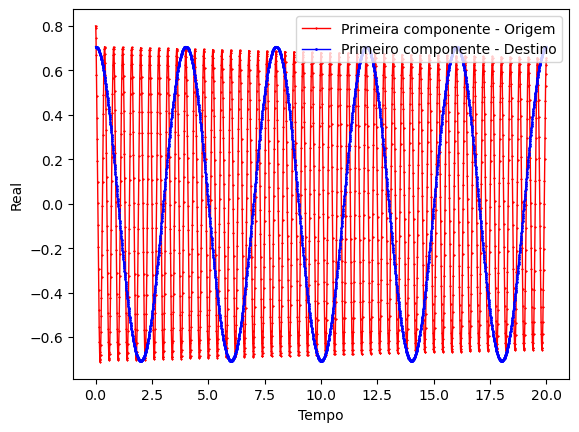

In [4]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

RealO = [ele.real for ele in Resp[0]] 
ImagO = [ele.imag for ele in Resp[0]] 

sup = []
for i in range(0, 2000):
    sup.append(1/np.sqrt(2)*np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100))
RealS = [ele.real for ele in sup]
ImagS = [ele.imag for ele in sup]

sub = []
for i in range(0, 2000):
    sub.append((abs(Resp[0][i]) - abs(sup[i])))

# Plotagem
plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.plot(ts, RealO, color='r', marker='*', linewidth=1, markersize=1, label="Primeira componente - Origem")
plt.plot(ts, RealS, color='b', marker='o',  linewidth=1, markersize=1, label="Primeiro componente - Destino")
plt.legend(loc='upper right')
plt.savefig('rk_otimo1.png', format='png')
plt.show()

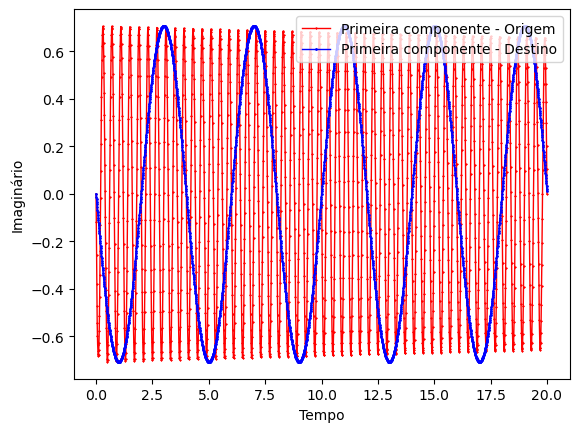

In [5]:
plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.plot(ts, ImagO, color='r', marker='*', linewidth=1, markersize=1, label="Primeira componente - Origem")
plt.plot(ts, ImagS, color='b', marker='o',  linewidth=1, markersize=1, label="Primeira componente - Destino")
plt.legend(loc='upper right')
plt.savefig('rk_otimo2.png', format='png')
plt.show()

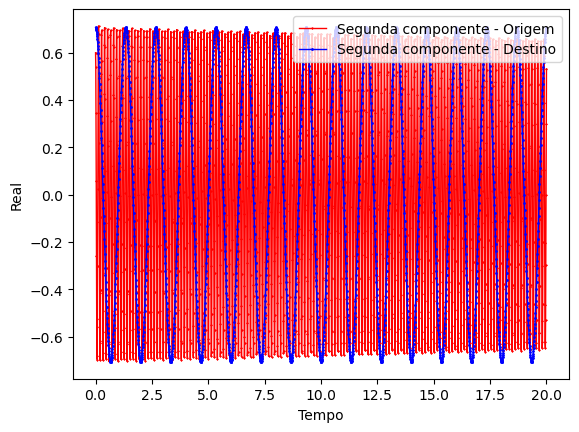

In [6]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

RealO = [ele.real for ele in Resp[1]] 
ImagO = [ele.imag for ele in Resp[1]] 

sup = []
for i in range(0, 2000):
    sup.append(1/np.sqrt(2)*np.exp(-1*complex(0,1)*(3/2*np.pi)*i/100))
RealS = [ele.real for ele in sup]
ImagS = [ele.imag for ele in sup]

subr = []
for i in range(0, 2000):
    subr.append((abs(Resp[1][i]) - abs(sup[i])))

# Plotagem
plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.plot(ts, RealO, color='r', marker='*', linewidth=1, markersize=1, label="Segunda componente - Origem")
plt.plot(ts, RealS, color='b', marker='o',  linewidth=1, markersize=1, label="Segunda componente - Destino")
plt.legend(loc='upper right')
plt.savefig('rk_otimo3.png', format='png')
plt.show()

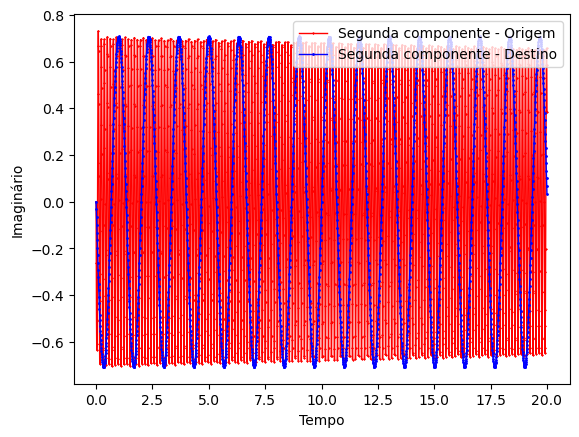

In [7]:
plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.plot(ts, ImagO, color='r', marker='*', linewidth=1, markersize=1, label="Segunda componente - Origem")
plt.plot(ts, ImagS, color='b', marker='o',  linewidth=1, markersize=1, label="Segunda componente - Destino")
plt.legend(loc='upper right')
plt.savefig('rk_otimo4.png', format='png')
plt.show()

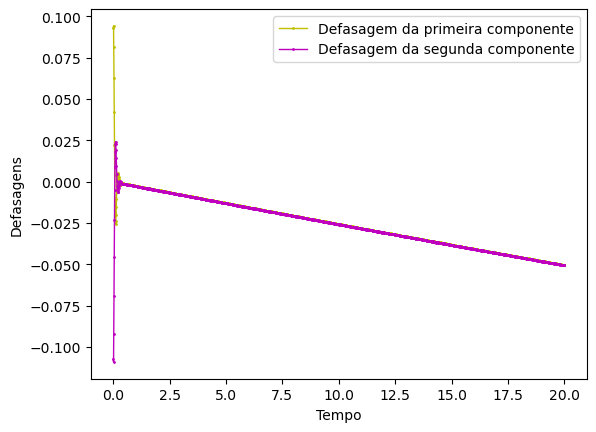

In [8]:
plt.ylabel('Defasagens') 
plt.xlabel('Tempo') 
plt.plot(ts, sub, color='y', marker='o',  linewidth=1, markersize=1, label="Defasagem da primeira componente")
plt.plot(ts, subr, color='m', marker='o',  linewidth=1, markersize=1, label="Defasagem da segunda componente")
plt.legend(loc="upper right")
plt.savefig('phases.png', format='png')
plt.show()

#### Valor da defasagem

In [9]:
print(subr[999])

-0.02577981353714698


Mesma defasagem em ambas as componentes representa uma defasagem global idêntica que pode ser desprezada.

## Gráficos - Avaliação das constantes da função de onda

Outra interpretação pertinente é a obtenção das constantes de onda, pois o objetivo inicial da pesquisa é sair de uma constante e chegar em um estado de forma que estas estajam em total equilíbrio. Para realizar a plotagem com os diversos números complexos se faz o uso do número absoluto que para o estudo do conjunto complexo representa o seu tamanho, dessa forma, é possível indentificar se o estado inicial alcançou o final desejado.

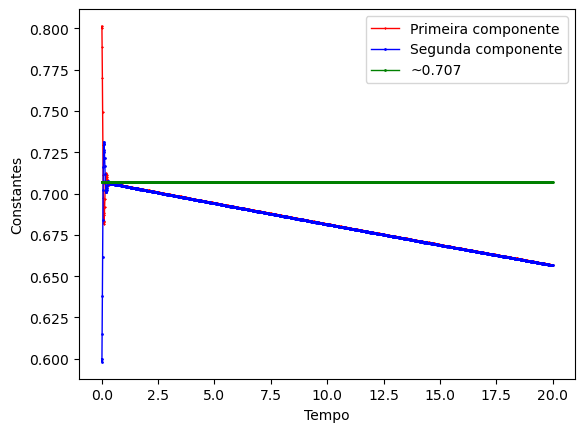

In [10]:
ts = np.linspace(0, 20, 2000) # Tempo em x 
const = []
for i in range(0, 2000):
    const.append(1/np.sqrt(2))

# Plotagem
plt.ylabel('Constantes') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(Constantes[0]), color='r', marker='*', linewidth=1, markersize=1, label="Primeira componente")
plt.plot(ts, abs(Constantes[1]), color='b', marker='o',  linewidth=1, markersize=1, label="Segunda componente")
plt.plot(ts, const, color='g', marker='o',  linewidth=1, markersize=1, label="~0.707")
plt.legend(loc="upper right")
plt.savefig('const.png', format='png')
plt.show()

## Gráficos - Avaliação da densidade de probabilidade para encontrar uma partícula no ponto x

Conforme descrito durante os capítulos 1, 2 e 3 do livro Mecânica Quântica por David Griffths, a estatística é um dos principais pontos para o entendimento da mecânica quântica, dessa forma é interessante entender qual é a probabilidade de uma partícula estar em um determinado lugar em um certo tempo e para tal se define:$$\int |\Psi(x,t)|^{2}dx = 1$$ Ainda nessa perspectiva, foi definido que o resultado da equação de Schrödinger pode ser definido a partir da escolha do potêncial V(x,t) e ainda que os enumeros resultados podem formar outros por meio de uma combinação linear de forma que o conjunto do quadrado das constantes que o formam, em sua soma resultam em 1. Isso define a probabilidade de um estado. Para este estudo considerou-se dois estados: $$0.80\psi_0(x,t)+0.60\psi_1(x,t)$$ de forma que para o primeiro estado a probabilidade é de 64% enquanto para o segundo é de 36%.

Se torna claro que a probabilidade total deve ser 1 e definindo o produto interno como $\int |\Psi(x,t)|^{2}dx = <\Psi | \Psi> = 1 = \sum_n |c_n|²$ podemos verificar se o ajuste da pesquisa está correto avaliando as constantes que são alteradas conforme o tempo de acordo com o gráfico apresentado acima.

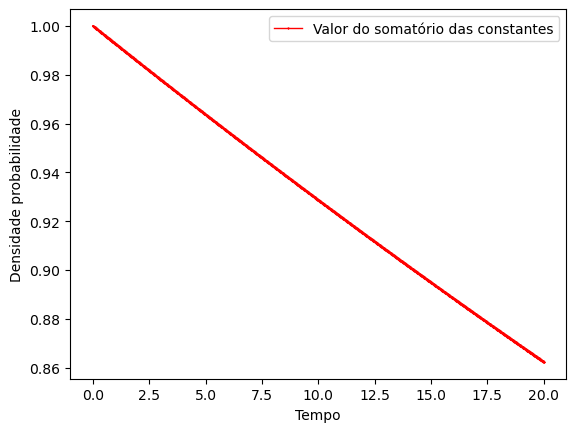

In [11]:
# Plotagem

dp = []
for i in range(0, 2000):
    dp.append((abs(Constantes[0][i])**2+abs(Constantes[1][i])**2))
    
plt.ylabel('Densidade probabilidade') 
plt.xlabel('Tempo') 
plt.plot(ts, dp, color='r', marker='*', linewidth=1, markersize=1, label="Valor do somatório das constantes")
plt.legend(loc="upper right")
plt.savefig('dp.png', format='png')
plt.show()

## Organização e gráfico da função objetivo

Nessa etapa do trabalho se torna importante verificar como a função objetivo está se comportando durante o projeto. Além disso, nessa seção, organiza-se algumas informações relevantes acerca do trabalho.

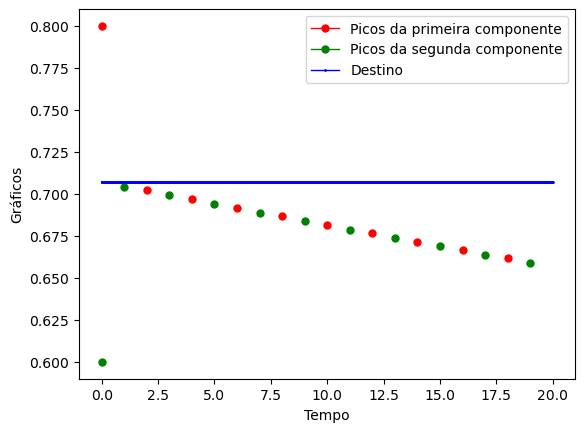

In [12]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

teste = np.zeros((2, 2000), dtype=np.complex_)
for i in range(0, 2000):
    teste[0][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100))
    
def zero_to_nan(values):
    return [float('nan') if x==0 else x for x in values]

# Plotagem
plt.ylabel('Gráficos') 
plt.xlabel('Tempo') 
plt.plot(ts, zero_to_nan(abs(Pico[0])), color='r', marker='o', linewidth=1, markersize=5, label="Picos da primeira componente")
plt.plot(ts, zero_to_nan(abs(Pico[1])), color='g', marker='o', linewidth=1, markersize=5, label="Picos da segunda componente")
plt.plot(ts, abs(teste[0]), color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc="upper right")
plt.savefig('pico.png', format='png')
plt.show()

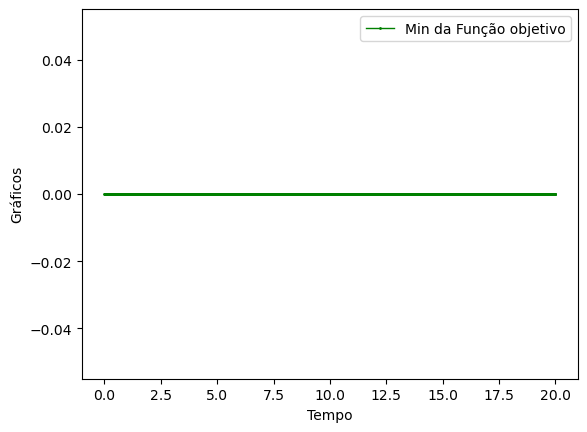

In [13]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Gráficos') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(Min[0]), color='g', marker='o', linewidth=1, markersize=1, label="Min da Função objetivo")
plt.legend(loc="upper right")
plt.savefig('min.png', format='png')
plt.show()

## Aumento do horizonte

É notável que a função objetivo não alcançou totalmente o zero e a justificativa para tal resultado pode estar no horizonte escolhido para a análise. Por mais que possamos aumentar o horizonte vale ressaltar que o seu aumento tem um custo computacional exponencial.

#### Aumento para 6

In [14]:
def fo(x, D, H, i, psi0):
    
    H1 = np.zeros((2,2), dtype=np.complex_)
    H1 = [[0, x[0]], [x[0], 0]]
    
    ## Tamanho do horizonte
    tam = 6
    
    M = np.zeros((2,1),dtype=np.complex_)
    M = [[psi0[0][0]], [psi0[1][0]]] 
    
    Result = np.zeros((2,1),dtype=np.complex_)
    
    Return = 0

    Z = np.zeros((2,1),dtype=np.complex_)
    Z[0][0] = D[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100)
    Z[1][0] = D[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*i/100)
    Return += (np.linalg.norm(M-Z))**2
    Result = rungeKutta(M, h, somar(H,H1), t = 2/100, t0 = 0)
    M = Result
    
    teste = tam + i
    
    ## Função-Objetivo (Return) = somatorio ||(Matriz_Origem - Matriz_Destino)||^2
    for p in range(i+1, teste):
        Z = np.zeros((2,1),dtype=np.complex_)
        Z[0][0] = D[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*p/100)
        Z[1][0] = D[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*p/100)
        Return += (np.linalg.norm(M-Z))**2
        H1 = [[0, x[p-i]], [x[p-i], 0]] # Controle
        Result = rungeKutta(M, h, somar(H,H1), t = ((p-i)+2)/100, t0 = ((p-i)/100))
        M = Result
    
    return Return

In [15]:
# Horizonte de análise
tam = 6
i = 0 # Iteração
h = 0.01 # Fator Runge-Kutta

# Proposta dos pontos
x = []
x.append(random.uniform(-1, 1))
for l in range(1, tam):
    x.append(x[0])

# Função de origem e destino
psi0 = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
psid = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]


H = np.zeros((2,2), dtype=np.complex_) # Hamiltoniano
A = (1/2*np.pi)
B = (3/2*np.pi)
H = [[A, 0], [0, B]]

D = np.zeros((2,1), dtype=np.complex_) # Matriz destino
D[0][0] = psid[0][0]
D[1][0] = psid[1][0]

Resp_h = np.zeros((2, 2000), dtype=np.complex_)
Constantes_h = np.zeros((2, 2000), dtype=np.complex_)
Pico_h = np.zeros((2, 2000), dtype=np.complex_)
Min_h = np.zeros((1,2000), dtype=np.complex_)
Obj_h = np.zeros((1,2000), dtype=np.complex_)
aly1 = 0
aly2 = 1
Pico_h[1][i] = complex(0.60,0.0)

while i < 2000:
    
    Resp_h[0][i] = psi0[0][0]
    Resp_h[1][i] = psi0[1][0]
    
    # Constantes da função de onda
    Constantes_h[0][i] = psi0[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100)
    Constantes_h[1][i] = psi0[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*i/100)
    
    # Picos
    
    if(i == aly1*(100/(1/2))):
        Pico_h[0][i] = psi0[0][0]
        aly1=aly1+1
        
    if(i == aly2*(100)):
        Pico_h[1][i] = psi0[1][0]
        aly2=aly2+2
    
    resultado = optimize.minimize(fo, x, args=(D, H, i, psi0), method='CG')
    
    print(resultado)
    
    # Função objetivo
    Min_h[0][i] = resultado.x[0]
    
    Obj_h[0][i] = fo(resultado.x, D, H, i, psi0)
    
    ## Hamiltoniano corntrolado
    u = np.zeros((2,1), dtype=np.complex_)
    u = [[0, resultado.x[0]],[resultado.x[0], 0]]
    H = somar(H, u)
    
    ## Adaptação da onda ao controle
    psi_t = np.zeros((2,2), dtype=np.complex_)
    psi_t = rungeKutta(psi0, h, H, t = 2, t0 = 0)
    
    psi0[0][0] = psi_t[0][1]
    psi0[1][0] = psi_t[1][1]
    
    H = [[A, 0], [0, B]]
    
    x = []
    for l in range(0, tam):
        x.append(resultado.x[l])

    i += 1

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
ts = np.linspace(0, 20, 2000) # Tempo em x 
const = []
for i in range(0, 2000):
    const.append(1/np.sqrt(2))

# Plotagem
plt.ylabel('Constantes') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(Constantes_h[0]), color='r', marker='*', linewidth=1, markersize=1, label="Primeira componente")
plt.plot(ts, abs(Constantes_h[1]), color='b', marker='o',  linewidth=1, markersize=1, label="Segunda componente")
plt.plot(ts, const, color='g', marker='o',  linewidth=1, markersize=1, label="~0.707")
plt.legend(loc="upper right")
plt.savefig('const_h.png', format='png')
plt.show()

In [ ]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

teste = np.zeros((2, 2000), dtype=np.complex_)
for i in range(0, 2000):
    teste[0][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100))
    
def zero_to_nan(values):
    return [float('nan') if x==0 else x for x in values]

# Plotagem
plt.ylabel('Gráficos') 
plt.xlabel('Tempo') 
plt.plot(ts, zero_to_nan(abs(Pico_h[0])), color='r', marker='o', linewidth=1, markersize=5, label="Picos da primeira componente")
plt.plot(ts, zero_to_nan(abs(Pico_h[1])), color='g', marker='o', linewidth=1, markersize=5, label="Picos da segunda componente")
plt.plot(ts, abs(teste[0]), color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc="upper right")
plt.savefig('pico_h.png', format='png')
plt.show()

In [ ]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Gráficos') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(Min_h[0]), color='g', marker='o', linewidth=1, markersize=1, label="Min da Função objetivo")
plt.legend(loc="upper right")
plt.savefig('min_h.png', format='png')
plt.show()

In [ ]:
# Plotagem
plt.ylabel('Constantes') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(Constantes[0]), color='g', marker='*', linewidth=1, markersize=1, label="Primeira componente")
plt.plot(ts, abs(Constantes[1]), color='y', marker='o',  linewidth=1, markersize=1, label="Segunda componente")
plt.plot(ts, abs(Constantes_h[0]), color='r', marker='*', linewidth=1, markersize=1, label="Primeira componente - Horizonte")
plt.plot(ts, abs(Constantes_h[1]), color='b', marker='o',  linewidth=1, markersize=1, label="Segunda componente - Horizonte")
plt.plot(ts, const, color='g', marker='o',  linewidth=1, markersize=1, label="~0.707")
plt.legend(loc="upper right")
plt.savefig('comparacoes.png', format='png')
plt.show()

In [ ]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Gráficos') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(Min[0]), color='g', marker='o', linewidth=1, markersize=1, label="Min da Função objetivo")
plt.plot(ts, abs(Min_h[0]), color='r', marker='o', linewidth=1, markersize=1, label="Min da Função objetivo - Horizonte")
plt.legend(loc="upper right")
plt.savefig('min_comparacoes.png', format='png')
plt.show()

#### Aumento para 8

In [ ]:
def fo(x, D, H, i, psi0):
    
    H1 = np.zeros((2,2), dtype=np.complex_)
    H1 = [[0, x[0]], [x[0], 0]]
    
    ## Tamanho do horizonte
    tam = 8
    
    M = np.zeros((2,1),dtype=np.complex_)
    M = [[psi0[0][0]], [psi0[1][0]]] 
    
    Result = np.zeros((2,1),dtype=np.complex_)
    
    Return = 0

    Z = np.zeros((2,1),dtype=np.complex_)
    Z[0][0] = D[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100)
    Z[1][0] = D[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*i/100)
    Return += (np.linalg.norm(M-Z))**2
    Result = rungeKutta(M, h, somar(H,H1), t = 2/100, t0 = 0)
    M = Result
    
    teste = tam + i
    
    ## Função-Objetivo (Return) = somatorio ||(Matriz_Origem - Matriz_Destino)||^2
    for p in range(i+1, teste):
        Z = np.zeros((2,1),dtype=np.complex_)
        Z[0][0] = D[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*p/100)
        Z[1][0] = D[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*p/100)
        Return += (np.linalg.norm(M-Z))**2
        H1 = [[0, x[p-i]], [x[p-i], 0]] # Controle
        Result = rungeKutta(M, h, somar(H,H1), t = ((p-i)+2)/100, t0 = (p-i)/100)
        M = Result
    
    return Return

In [ ]:
# Horizonte de análise
tam = 8
i = 0 # Iteração
h = 0.01 # Fator Runge-Kutta

# Proposta dos pontos
x = []
x.append(random.uniform(-1, 1))
for l in range(1, tam):
    x.append(x[0])

# Função de origem e destino
psi0 = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
psid = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]


H = np.zeros((2,2), dtype=np.complex_) # Hamiltoniano
A = (1/2*np.pi)
B = (3/2*np.pi)
H = [[A, 0], [0, B]]

D = np.zeros((2,1), dtype=np.complex_) # Matriz destino
D[0][0] = psid[0][0]
D[1][0] = psid[1][0]

Resp_h2 = np.zeros((2, 2000), dtype=np.complex_)
Constantes_h2 = np.zeros((2, 2000), dtype=np.complex_)
Pico_h2 = np.zeros((2, 2000), dtype=np.complex_)
Obj_h2 = np.zeros((1,2000), dtype=np.complex_)
Min_h2 = np.zeros((1,2000), dtype=np.complex_)
aly1 = 0
aly2 = 1
Pico_h2[1][i] = complex(0.60,0.0)

while i < 2000:
    
    Resp_h2[0][i] = psi0[0][0]
    Resp_h2[1][i] = psi0[1][0]
    
    # Constantes da função de onda
    Constantes_h2[0][i] = psi0[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100)
    Constantes_h2[1][i] = psi0[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*i/100)
    
    # Picos
    
    if(i == aly1*(100/(1/2))):
        Pico_h2[0][i] = psi0[0][0]
        aly1=aly1+1
        
    if(i == aly2*(100)):
        Pico_h2[1][i] = psi0[1][0]
        aly2=aly2+2
    
    resultado = optimize.minimize(fo, x, args=(D, H, i, psi0), method='CG')
    
    print(resultado)
    
    # Função objetivo
    Min_h2[0][i] = resultado.x[0]
    
    Obj_h2[0][i] = fo(resultado.x, D, H, i, psi0)
    
    ## Hamiltoniano corntrolado
    u = np.zeros((2,1), dtype=np.complex_)
    u = [[0, resultado.x[0]],[resultado.x[0], 0]]
    H = somar(H, u)
    
    ## Adaptação da onda ao controle
    psi_t = np.zeros((2,2), dtype=np.complex_)
    psi_t = rungeKutta(psi0, h, H, t = 2, t0 = 0)
    
    psi0[0][0] = psi_t[0][1]
    psi0[1][0] = psi_t[1][1]
    
    H = [[A, 0], [0, B]]
    
    x = []
    for l in range(0, tam):
        x.append(resultado.x[l])

    i += 1

In [ ]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Gráficos') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(Min[0]), color='g', marker='o', linewidth=1, markersize=1, label="Mínimo da Função objetivo")
plt.plot(ts, abs(Min_h[0]), color='r', marker='o', linewidth=1, markersize=1, label="Min da Função objetivo - Horizonte")
plt.plot(ts, abs(Min_h2[0]), color='y', marker='o', linewidth=1, markersize=1, label="Min da Função objetivo - Amplificado")
plt.legend(loc="upper right")
plt.savefig('min_comparacoes1.png', format='png')
plt.show()

In [ ]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Gráficos') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(Obj[0]), color='g', marker='o', linewidth=1, markersize=1, label="Função objetivo")
plt.plot(ts, abs(Obj_h[0]), color='r', marker='o', linewidth=1, markersize=1, label="Função objetivo - Horizonte")
plt.plot(ts, abs(Obj_h2[0]), color='y', marker='o', linewidth=1, markersize=1, label="Função objetivo - Amplificado")
plt.legend(loc="upper right")
plt.savefig('obj_comparacoes.png', format='png')
plt.show()